National Research University "Higher School of Economics"

Master of Data Science Online Programme

Course: Introduction to Deep Learning

Final Project: Natural Language Processing (Part 2)

Student: Andrei Batyrov (Fall2022)

Date: 3-Dec-2023

##### Table of Contents

[Description](#description)

[Part 2: Natural Language Processing](#nlp)

1. [Data Analysis](#data-analysis)

2. [RuBERT on RuCoLa](#rubert)

3. [mBERT on RuCoLa](#mbert)

4. [mBERT on RuCoLa + CoLa](#mbert-aug)

5. [Summary](#summary)




In [1]:
# Essential import
import gc
import json
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, matthews_corrcoef
from tqdm import tqdm
import matplotlib.pyplot as plt
seed = 13
batch_size = 32 # Train / validate on this many examples per batch
torch.manual_seed(seed=seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device = }')

device = device(type='cuda')


Some helper functions.

In [2]:
def plot_bar(df, x, y, xlabel, title, kind='vertical', bar_label=False, ylim=None, rot=0, err=None):
    '''
    Plot bar plot, where `x` and `y` are column names of Pandas Dataframe `df`.
    '''
    if kind not in ('vertical', 'horizontal'):
        raise ValueError("kind must be 'vertical' or 'horizontal'")
    if kind == 'vertical':
        plt.figure(figsize=(6, 4))
        bars = plt.bar(range(df[x].shape[0]), df[y].values, yerr=err, width=0.25, align='center', color='white', alpha=0.75, hatch='.'*6, error_kw={'lw': 0.5, 'capsize': 1})
        plt.xlabel(xlabel, size=10, family='monospace')
        plt.xticks(range(df[x].shape[0]), df[x].values)
        plt.ylim(ylim)
        plt.grid(axis='y', lw=0.5, color='xkcd:cement')
    else: # kind == 'horizontal'
        plt.figure(figsize=(6, 4))
        bars = plt.barh(range(df[x].shape[0]), df[y].values, xerr=err, height=0.25, align='center', color='white', alpha=0.75, hatch='.'*6, error_kw={'lw': 0.5, 'capsize': 1})
        plt.gca().invert_yaxis()
        plt.xlabel(xlabel, size=10, family='monospace')
        plt.yticks(range(df[x].shape[0]), df[x].values)
        plt.grid(axis='x', lw=0.5, color='xkcd:cement')
    for i in range(len(bars)):
        bars[i].set_edgecolor(f'C{i}')
    plt.xticks(rotation=rot)
    if bar_label:
        plt.gca().bar_label(plt.gca().containers[0], fmt='{:.3f}', label_type='edge', padding=5, fontsize=9)
    plt.gca().set_axisbelow(True)
    plt.title(title, size=10, family='monospace');

In [3]:
def prepare_data(model, dataset):
    '''
    Tokenize all sentences in `dataset` Pandas DataFrame and prepare data for DataLoader.
    The first column must me sentences, and the second column must be labels.
    Tokenizer is used from `model`.
    Source: https://mccormickml.com/2019/07/22/BERT-fine-tuning/
    '''
    sentences = dataset.iloc[:, 0].values
    labels = dataset.iloc[:, 1].values
    input_ids = []
    attention_masks = []
    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        # - Tokenize the sentence
        # - Prepend the `[CLS]` token to the start
        # - Append the `[SEP]` token to the end
        # - Map tokens to their IDs
        # - Pad or truncate the sentence to `max_length`
        # - Create attention masks for [PAD] tokens
        encoded_dict = model.tokenizer.encode_plus(
                            sent,                       # Sentence to encode
                            add_special_tokens=True,    # Add '[CLS]' and '[SEP]'
                            max_length=model.max_len,   # Pad and truncate all sentences
                            padding='max_length',
                            truncation=True,
                            return_attention_mask=True, # Construct attn. masks
                            return_tensors='pt',        # Return pytorch tensors
                    )
        # Add the encoded sentence to the list
        input_ids.append(encoded_dict['input_ids'])
        # And its attention mask (simply differentiates padding from non-padding)
        attention_masks.append(encoded_dict['attention_mask'])
    # Convert the lists into tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    # Combine into one tensor
    prepared = torch.utils.data.TensorDataset(input_ids, attention_masks, labels)
    return prepared

In [4]:
def test_model(model, test_dataset, verbose=False):
    '''
    Compute mean accuracy score and MCC of the `model` on the given `test_dataset` over all batches.
    '''
    # 1. Switch to eval mode
    model.model.eval()
    # 2. Prepare data
    prepared_test = prepare_data(model, test_dataset)
    # 3. Create data loader
    test_loader = torch.utils.data.DataLoader(prepared_test, batch_size=batch_size, shuffle=True, num_workers=4)
    # 4. Do eval loop for all batches
    accs = []
    mccs = []
    n_batches_to_show = np.ceil(len(test_loader) / 10)
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
            # `data` has 3 tensors, as returned by `prepare_data()`
            input_ids = data[0].to(device)
            input_mask = data[1].to(device)
            labels = data[2].to(device)
            output = model.model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels)
            # Loss is not needed here
            logits = output.logits
            # Convert to numpy for sklearn
            y_pred = logits.argmax(-1).detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, y_pred)
            mcc = matthews_corrcoef(labels, y_pred)
            accs.append(acc)
            mccs.append(mcc)
            if verbose:
                if i % n_batches_to_show == 0:
                    print(f'Batch: {i:>3}, Accuracy: {acc:.2f}, MCC: {mcc:.2f}')
                    
    return np.mean(accs), np.mean(mccs)

In [5]:
def save_metrics(model_name, **metrics):
    '''
    Dump train/val loss and accuracy lists to a json file.
    '''
    with open(f'./metrics/{model_name}.json', 'w') as fh:
        json.dump(metrics, fh)

In [6]:
def load_metrics(model_name):
    '''
    Load train/val loss and accuracy lists from a json file.
    '''
    try:
        with open(f'./metrics/{model_name}.json', 'r') as fh:
            return json.load(fh)
    except:
        raise RuntimeError(f'The metrics json file not found. Was the model `{model_name}` trained?')

In [7]:
def train_model(model, train_subset, val_subset, epochs):
    if not model.is_trained:
        print(f'Training model `{model.name}`.')
        lr = 2e-5
        optimizer = torch.optim.AdamW(model.model.parameters(), lr=lr, eps=1e-8)
        model.train(train_subset, val_subset, optimizer, epochs)
        model.is_trained = True
        # Save model's state and train/val metrics to disk
        torch.save(model.model.state_dict(), f'./models/{model.name}.pt')
        save_metrics(model.name, train_losses=model.train_losses, val_losses=model.val_losses, train_accs=model.train_accs, val_accs=model.val_accs)
        print('Model successfully trained and saved to disk.')
    else:
        print('Model is already trained.')

In [8]:
def load_model(model):
    '''
    Try to find and load our fine-tuned model.
    '''
    try:
        model.model.load_state_dict(torch.load(f'./models/{model.name}.pt'))
        model.model = model.model.to(device)
        model.is_trained = True
        print(f'Found fine-tuned model `{model.name}.pt`. Ready for inferring/testing.')
    except:
        print(f'Fine-tuned model `{model.name}` not found. Train/eval the model first.')

In [9]:
def plot_metrics(model_name: str, epochs):
    '''
    Plot model's loss and accuracy metrics obtained during train/val over the number of `epochs`.
    '''
    metrics = load_metrics(model_name)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), metrics['train_losses'], marker='s', color='C0', label='Train')
    plt.plot(range(1, epochs+1), metrics['val_losses'], marker='s', color='C1', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(1, epochs+1))
    plt.legend()
    plt.grid(lw=0.5)
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), metrics['train_accs'], marker='s', color='C0', label='Train')
    plt.plot(range(1, epochs+1), metrics['val_accs'], marker='s', color='C1', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, epochs+1))
    plt.legend()
    plt.grid(lw=0.5)
    plt.suptitle(f'Train and validation datasets metrics: {model_name}', fontsize=11)
    plt.tight_layout();

---
# <a id="description"></a>Description of the final project

## Introduction

This project consists of two parts. The first part is devoted to Computer Vision and based on the first four weeks of the course. The second part is on Natural Language Processing and based on weeks 5 and 6. 


## Detailed Task Description


### <a id="nlp"></a>Part 2: Natural Language Processing

In this part you will have to work with different versions of BERT model and use it to solve the [RuCoLa](https://rucola-benchmark.com/) task.

In the task you should perform all the model training on `in_domain_train.csv` data and evaluate your models on `in_domain_dev.csv`. Note that you do not need `test.csv`.

Use **[accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)** and **[MCC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)** metrics for scoring.

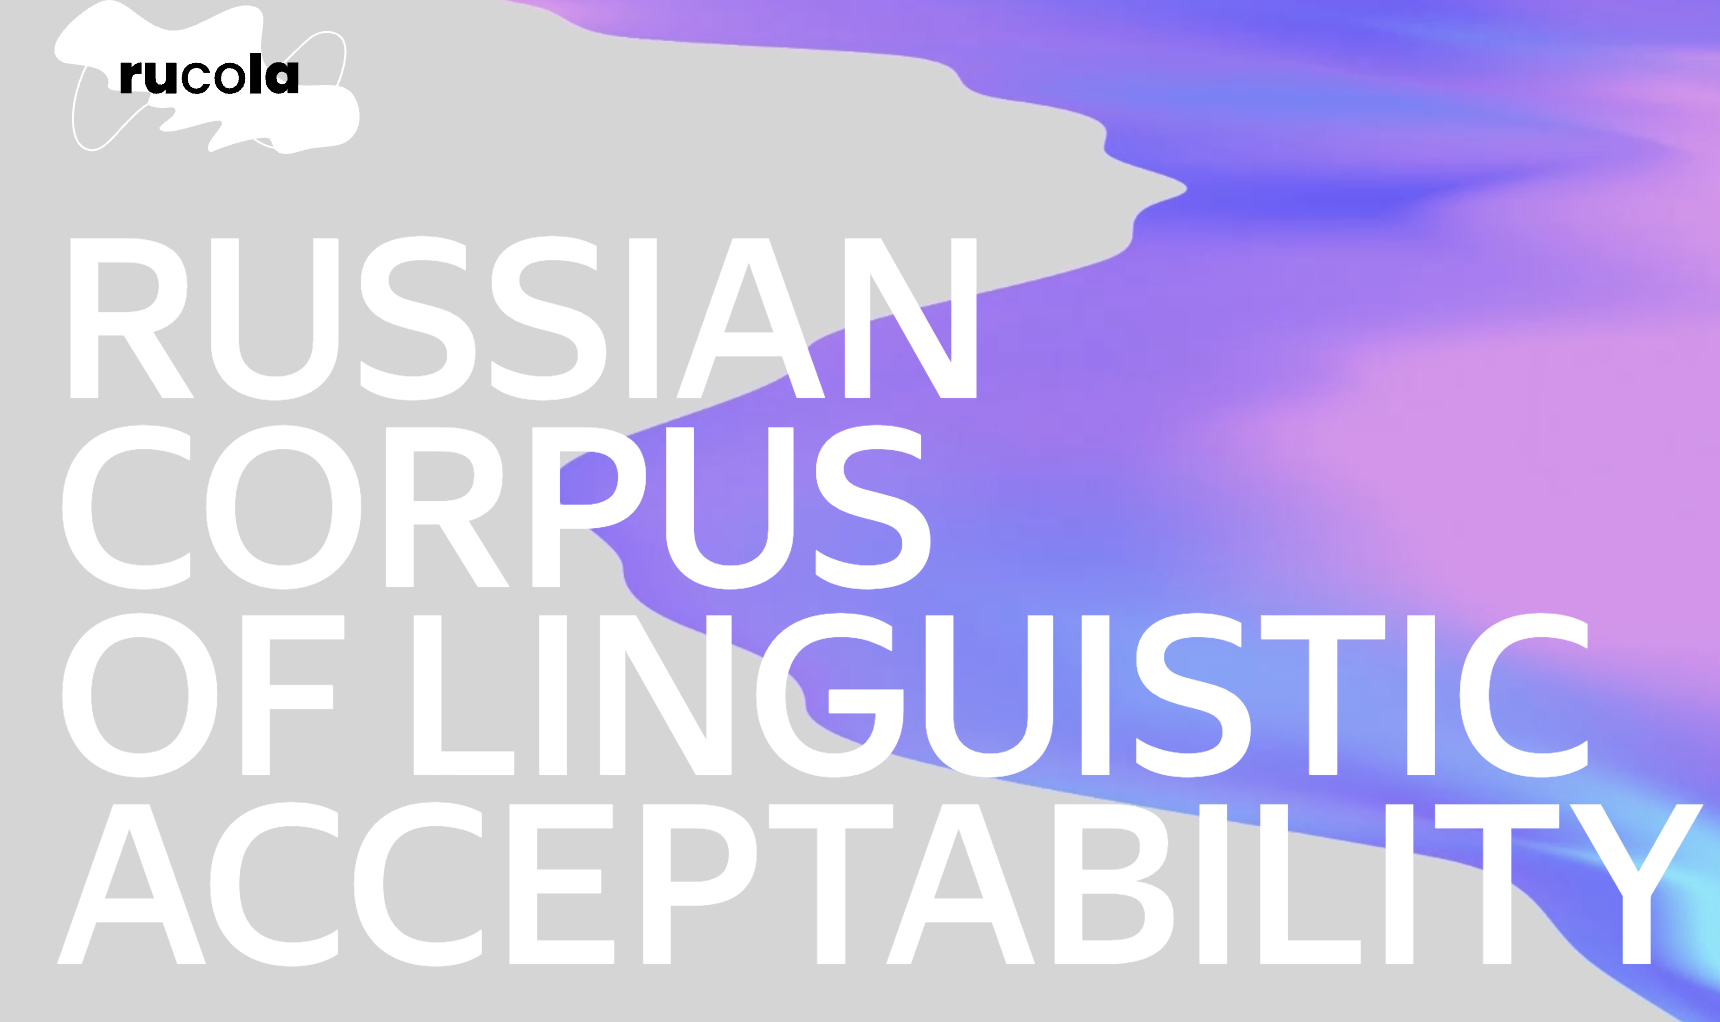

### <a id="data-analysis"></a>[7%] 1. Data analysis 

* 1.1  (5%) [Download](https://github.com/RussianNLP/RuCoLA/tree/main/data) the data(you need only `in_domain_train.csv` for training and  `in_domain_dev.csv` for the evaluation) and calculate basic statistics (example number, class distribution, mean sentence length, number of unique words, etc.) and make visualizations, if necessary.

In [10]:
data = pd.read_csv('https://raw.githubusercontent.com/RussianNLP/RuCoLA/main/data/in_domain_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/RussianNLP/RuCoLA/main/data/in_domain_dev.csv')

In [11]:
# Number of training sentences
data.shape

(7869, 5)

In [12]:
# Show 10 random training sentences
data.iloc[sorted(np.random.choice(data.shape[0], 10, replace=False))]

,id,sentence,acceptable,error_type,detailed_source
426,426,"Как выяснилось впоследствии, подлодку заметили...",1,0,Paducheva2010
1574,1574,Вася похож на Петю по характеру.,1,0,Rusgram
3840,3840,Звоните и уходите отсюда.,1,0,Paducheva2010
4764,4764,Он не ел мяса сырым.,1,0,Testelets
4862,4862,Всего мне достаточно.,0,Syntax,Rusgram
4961,4961,Как бы ни был предан своему делу и усерден упр...,1,0,Lutikova
6110,6110,"Я вижу, Джона здесь нет.",1,0,Paducheva2010
6115,6115,Мне нужно получить ботинки в мастерской.,1,0,Seliverstova
7012,7012,По вечерам они сидят возле своих телевизоров.,1,0,Seliverstova
7048,7048,Выступление юного скрипача было настолько эффе...,1,0,USE5


In [13]:
# Examine target
target = 'acceptable'

In [14]:
# Check nulls
data[target].isna().sum()

0

In [15]:
# Target distribution
data[target].value_counts(normalize=True)

acceptable
1    0.745203
0    0.254797
Name: proportion, dtype: float64

In [16]:
_ = pd.DataFrame(data[target].value_counts(ascending=True)).reset_index()
_

,acceptable,count
0,0,2005
1,1,5864


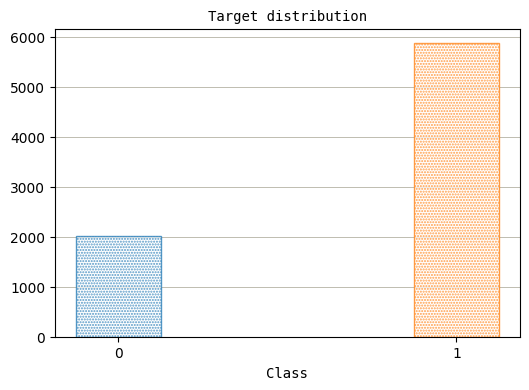

In [17]:
plot_bar(_, target, 'count', 'Class', 'Target distribution')

In [18]:
# Positive to negative classes imbalance ratio
_.iloc[1]['count'] / _.iloc[0]['count']

2.9246882793017455

In [19]:
# Mean sentence length in characters
data['sentence'].apply(len).mean()

54.973058838480114

In [20]:
# Mean sentence length in words, if split by whitespaces
data['sentence'].str.split().apply(len).mean()

8.55648748252637

In [21]:
# Max sentence length in words, if split by whitespaces
data['sentence'].str.split().apply(len).max()

26

In [22]:
# All words (bag of words)
bow = data['sentence'].str.replace('.', ' ').sum().split()
# Show 10 random words
np.array(bow)[np.random.choice(len(bow), 10, replace=False)]

array(['суть', 'Она', 'чистоту', 'Если', 'Князь', 'с', 'Родины', 'к',
       'привык', 'зависит'], dtype='<U31')

In [23]:
# Number of unique words
len(set(bow))

21254

In [24]:
# Top-10 most common words
Counter(bow).most_common(10)

[('не', 1762),
 ('в', 1596),
 ('и', 1410),
 ('на', 1029),
 ('что', 813),
 ('Я', 700),
 ('Он', 627),
 ('с', 622),
 ('он', 528),
 ('я', 473)]

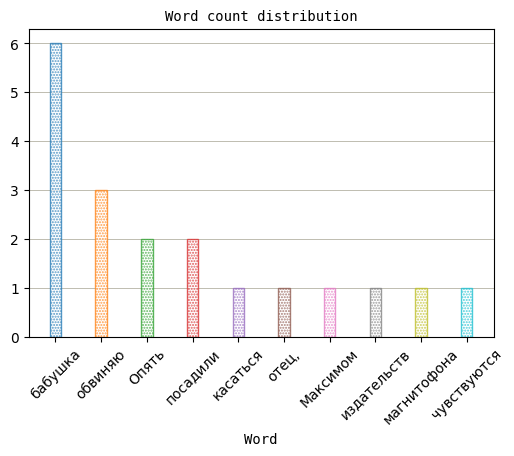

In [25]:
# Count distribution of 10 random words
_ = pd.DataFrame(Counter(bow).items()).iloc[np.random.choice(len(Counter(bow)), 10)].sort_values(by=1, ascending=False)
plot_bar(_, 0, 1, 'Word', 'Word count distribution', rot=45)

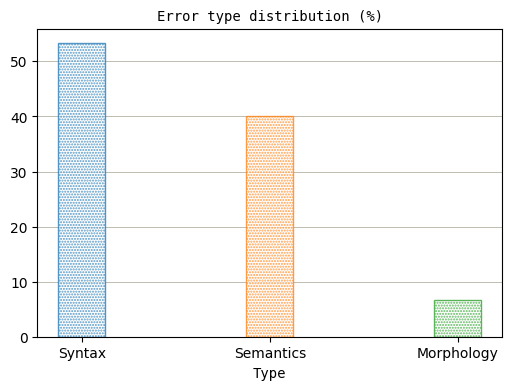

In [26]:
# Error type distribution
_ = pd.DataFrame(data[data['error_type'] != '0']['error_type'].value_counts(ascending=False, normalize=True)).mul(100).reset_index()
plot_bar(_, 'error_type', 'proportion', 'Type', 'Error type distribution (%)')

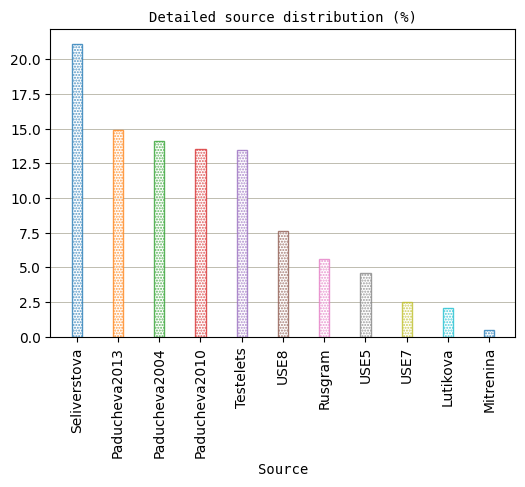

In [27]:
# Detailed source distribution
_ = pd.DataFrame(data['detailed_source'].value_counts(ascending=False, normalize=True)).mul(100).reset_index()
plot_bar(_, 'detailed_source', 'proportion', 'Source', 'Detailed source distribution (%)', rot=90)

* 1.2.  (2%) Split the data from `in_domain_train.csv` into train and val (`val_size = 10%`). Do not forget to fix `random_state` for reproducibility.

In [28]:
# Stratified split, since target classes are imbalanced
train, val = train_test_split(data, test_size=0.1, stratify=data[target], random_state=seed)

In [29]:
# Checks split
(
    np.allclose(train.shape[0] / data.shape[0], 0.9, atol=1e-4), # Train 90%
    np.allclose(val.shape[0] / data.shape[0], 0.1, atol=1e-4), # Validation 10%
)

(True, True)

In [30]:
train[target].value_counts(normalize=True)

acceptable
1    0.74527
0    0.25473
Name: proportion, dtype: float64

In [31]:
val[target].value_counts(normalize=True)

acceptable
1    0.7446
0    0.2554
Name: proportion, dtype: float64

### <a id="rubert"></a>[10%] 2. Fine-tune RuBERT

* 2.0 Study the [tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/) on BERT model fine-tuning.

**Note:** this part is not graded. However, you may find the material from the tutorial useful  for the successful task completion.

* 2.1 Take RuBert model (BERT for the Russian language). You may use any other BERT-like models for the Russian language from [Hugging Face](https://huggingface.co/) project. For example, you may use [`sberbank-ai/ruBert-base`](https://huggingface.co/sberbank-ai/ruBert-base) or [`DeepPavlov/rubert-base-cased`](https://huggingface.co/DeepPavlov/rubert-base-cased).

First, let's create a class (model factory) to build models based on some pre-trained ones, but with the untrained last classification layer. We will use it for all BERT models. The class will also have methods to train and validate models.

> Quick note: The data is not very large, so we can compute accuracy either directly on PyTorch tensors or with sklearn on NumPy arrays. We will compute accuracy directly without using sklearn during training / validation to avoid copying and converting from GPU to CPU in every batch. And for testing we will use sklearn to compute accuracy_score and MCC.

In [32]:
class RucolaClassifier:
    def __init__(self, base_model: str, max_len=64, verbose=False):
        # 1. Create an existing pre-trained model
        if base_model not in ('rubert', 'mbert', 'mbert_aug'):
            raise ValueError("base_model should be one of 'rubert', 'mbert', 'mbert_aug'")
        if base_model == 'rubert':
            # https://huggingface.co/ai-forever/ruBert-base
            name = 'rubert'
            model_str = 'sberbank-ai/ruBert-base'
            tokenizer_str = 'sberbank-ai/ruBert-base'
        elif base_model == 'mbert':
            # https://huggingface.co/bert-base-multilingual-cased
            name = 'mbert'
            model_str = 'bert-base-multilingual-cased'
            tokenizer_str = 'bert-base-multilingual-cased'
        else: # base_model == 'mbert_aug'
            # https://huggingface.co/bert-base-multilingual-cased
            name = 'mbert_aug'
            model_str = 'bert-base-multilingual-cased'
            tokenizer_str = 'bert-base-multilingual-cased'
        self.name = name
        self.model = BertForSequenceClassification.from_pretrained(model_str, num_labels = 2, output_attentions = False, output_hidden_states = False)
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_str)
        self.max_len = max_len
        self.is_trained = False
        self.verbose = verbose
        self.model = self.model.to(device)

    def train(self, train_subset, val_subset, optimizer, epochs: int):
        # 1. Prepare data
        prepared_train = prepare_data(self, train_subset)
        prepared_val = prepare_data(self, val_subset)
        # 2. Create data loaders
        self.train_loader = torch.utils.data.DataLoader(prepared_train, batch_size=batch_size, shuffle=True, num_workers=4)
        self.val_loader = torch.utils.data.DataLoader(prepared_val, batch_size=batch_size, shuffle=True, num_workers=4)
        # 3. Store optimizer
        self.optimizer = optimizer
        # 4. Do train and eval loop for the number of epochs
        self.train_losses, self.val_losses, self.train_accs, self.val_accs = [], [], [], []
        for epoch_i, _ in enumerate(range(epochs), start=1):
            print(f'-------------\nEpoch: {epoch_i:>2}/{epochs}')
            # Train one epoch
            self._train()
            # Eval one epoch
            self._validate()
    
    def _train(self):
        '''
        Train the classifier on all batches of the `train_loader` for one epoch.
        '''
        # 1. Switch to train mode
        self.model.train()
        # 2. Do train loop for all batches for one epoch
        print('\nTraining...')
        losses, accs = [], []
        n_batches_to_show = np.ceil(len(self.train_loader) / 10)
        for i, data in tqdm(enumerate(self.train_loader), total=len(self.train_loader)):
            # `data` has 3 tensors, as returned by `prepare_data()`
            input_ids = data[0].to(device)
            input_mask = data[1].to(device)
            labels = data[2].to(device)
            self.optimizer.zero_grad()
            output = self.model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels)
            loss = output.loss
            logits = output.logits
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            losses.append(loss.item())
            acc = torch.mean(logits.argmax(-1) == labels, dtype=float) # normalized accuracy_score (sklearn)
            accs.append(acc.item())
            if self.verbose:
                if i % n_batches_to_show == 0:
                    print(f'Batch: {i:>4}, Train loss: {loss:.2f}, Train accuracy: {acc:.2f}')
        # 3. Keep and report train metrics for one epoch
        epoch_mean_loss = np.mean(losses)
        self.train_losses.append(epoch_mean_loss)
        epoch_mean_acc = np.mean(accs)
        self.train_accs.append(np.mean(epoch_mean_acc))
        print(f'Epoch avg: Train loss: {epoch_mean_loss:.2f}, Train accuracy: {epoch_mean_acc:.2f}')

    def _validate(self):
        '''
        Validate the classifier on all batches of the `val_loader` for one epoch.
        '''
        # 1. Switch to eval mode
        self.model.eval()
        # 2. Do eval loop
        print('\nEvaluating...')
        losses, accs = [], []
        n_batches_to_show = np.ceil(len(self.val_loader) / 10)
        with torch.no_grad():
            for i, data in tqdm(enumerate(self.val_loader), total=len(self.val_loader)):
                # `data` has 3 tensors, as returned by `prepare_data()`
                input_ids = data[0].to(device)
                input_mask = data[1].to(device)
                labels = data[2].to(device)
                output = self.model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels)
                loss = output.loss
                logits = output.logits
                losses.append(loss.item())
                acc = torch.mean(logits.argmax(-1) == labels, dtype=float) # normalized accuracy_score (sklearn)
                accs.append(acc.item())
                if self.verbose:
                    if i % n_batches_to_show == 0:
                        print(f'Batch: {i:>3}, Val loss: {loss:.2f}, Val accuracy: {acc:.2f}')
        # 3. Keep and report val metrics for one epoch
        epoch_mean_loss = np.mean(losses)
        self.val_losses.append(epoch_mean_loss)
        epoch_mean_acc = np.mean(accs)
        self.val_accs.append(np.mean(epoch_mean_acc))
        print(f'Epoch avg: Val loss: {epoch_mean_loss:.2f}, Val accuracy: {epoch_mean_acc:.2f}')

In [33]:
# Create directories to store results
try:
    Path('./models').mkdir()
    print('`./models` directory successfully created.')
except Exception as e:
    print(str(e))
try:
    Path('./metrics').mkdir()
    print('`./metrics` directory successfully created.')
except Exception as e:
    print(str(e))

`./models` directory successfully created.
`./metrics` directory successfully created.


In [34]:
model_rubert = RucolaClassifier(base_model='rubert')
load_model(model_rubert)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruBert-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-tuned model `rubert` not found. Train/eval the model first.


* 2.2   (5%) Fine-tune RuBERT on RuCoLa train part created in 1.2. Do not forget about validation in process of training on val set created in 1.2. Select optimal epochs number, using the statistics on the val set.

In [35]:
train_model(model_rubert, train[['sentence', 'acceptable']], val[['sentence', 'acceptable']], epochs=3)

Training model `rubert`.
-------------
Epoch:  1/3

Training...


100%|██████████| 222/222 [01:02<00:00,  3.57it/s]


Epoch avg: Train loss: 0.53, Train accuracy: 0.76

Evaluating...


100%|██████████| 25/25 [00:04<00:00,  5.62it/s]


Epoch avg: Val loss: 0.53, Val accuracy: 0.77
-------------
Epoch:  2/3

Training...


100%|██████████| 222/222 [00:56<00:00,  3.93it/s]


Epoch avg: Train loss: 0.37, Train accuracy: 0.84

Evaluating...


100%|██████████| 25/25 [00:04<00:00,  5.80it/s]


Epoch avg: Val loss: 0.52, Val accuracy: 0.78
-------------
Epoch:  3/3

Training...


100%|██████████| 222/222 [00:56<00:00,  3.92it/s]


Epoch avg: Train loss: 0.21, Train accuracy: 0.92

Evaluating...


100%|██████████| 25/25 [00:04<00:00,  5.55it/s]


Epoch avg: Val loss: 0.65, Val accuracy: 0.78
Model successfully trained and saved to disk.


Let's plot the metrics for the `train` and `val`.

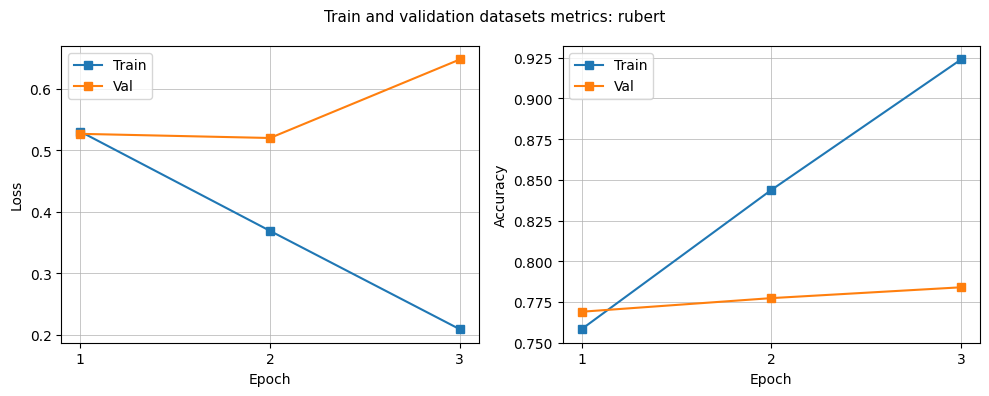

In [36]:
plot_metrics(model_rubert.name, epochs=3)

We trained our model for 3 epochs and can see that the model trains very quickly. And 2 epochs look to be enough, otherwise the model gets overfitted.

* 2.3  (5%) Evaluate your fine-tuned model (use accuracy and MCC metrics and `in_domain_dev.csv` for the evaluation), analyze the results and make conclusions.

In [37]:
acc_test_rubert, mcc_test_rubert = test_model(model_rubert, test[['sentence', 'acceptable']])

100%|██████████| 31/31 [00:05<00:00,  5.51it/s]


In [38]:
print(f'{acc_test_rubert = :.2%}')
print(f'{mcc_test_rubert = :.2f}')

acc_test_rubert = 78.91%
mcc_test_rubert = 0.35


The RuBERT model's accuracy for RuCoLa $\approx$ 79% and MCC > 0, i.e. the model's predictions are not random. So, we were able to fine-tune a large model for our task within some reasonable time, instead of building a new model from the scratch. In other words, we successfully applied the __transfer learning__ technique for our task.

In [39]:
# Done with this model, can clear the cuda cache now
del model_rubert
torch.cuda.empty_cache()
gc.collect()
torch.cuda.is_available()

True

### <a id="mbert"></a>[10%] 3. Fine-tune mBERT on RuCoLa

* 3.1 Now take a multilingual BERT model (BERT for the Russian language), or simply [mBERT](https://huggingface.co/bert-base-multilingual-cased) from [Hugging Face](https://huggingface.co/) project.

In [40]:
model_mbert = RucolaClassifier(base_model='mbert')
load_model(model_mbert)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-tuned model `mbert` not found. Train/eval the model first.


* 3.2   (5%) Similarly to 2, fine-tune mBERT on RuCoLa train part created in 1.2. Do not forget about validation in process of training on val set created in 1.2. Select optimal epochs number, using the statistics on the val set.

In [41]:
train_model(model_mbert, train[['sentence', 'acceptable']], val[['sentence', 'acceptable']], epochs=3)

Training model `mbert`.
-------------
Epoch:  1/3

Training...


100%|██████████| 222/222 [00:57<00:00,  3.85it/s]


Epoch avg: Train loss: 0.56, Train accuracy: 0.74

Evaluating...


100%|██████████| 25/25 [00:05<00:00,  4.86it/s]


Epoch avg: Val loss: 0.56, Val accuracy: 0.76
-------------
Epoch:  2/3

Training...


100%|██████████| 222/222 [00:57<00:00,  3.86it/s]


Epoch avg: Train loss: 0.51, Train accuracy: 0.78

Evaluating...


100%|██████████| 25/25 [00:04<00:00,  5.04it/s]


Epoch avg: Val loss: 0.54, Val accuracy: 0.78
-------------
Epoch:  3/3

Training...


100%|██████████| 222/222 [00:57<00:00,  3.86it/s]


Epoch avg: Train loss: 0.43, Train accuracy: 0.82

Evaluating...


100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


Epoch avg: Val loss: 0.55, Val accuracy: 0.77
Model successfully trained and saved to disk.


Let's plot the metrics for the `train` and `val`.

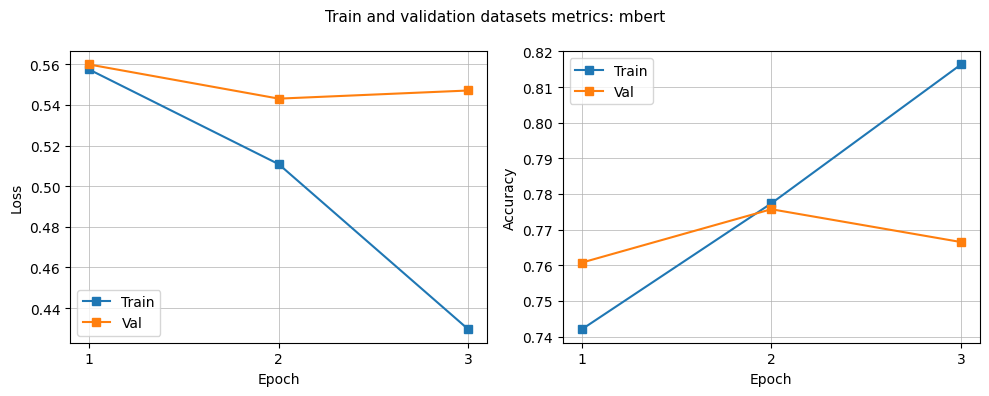

In [42]:
plot_metrics(model_mbert.name, epochs=3)

We trained our model for 3 epochs and can see that the model trains very quickly. And 2 epochs look to be enough, otherwise the model gets overfitted.

* 3.3  (5%) Evaluate your fine-tuned model (use accuracy and MCC metrics and `in_domain_dev.csv` for the evaluation), analyze the results and make conclusions.

In [43]:
acc_test_mbert, mcc_test_mbert = test_model(model_mbert, test[['sentence', 'acceptable']])

100%|██████████| 31/31 [00:05<00:00,  5.71it/s]


In [44]:
print(f'{acc_test_mbert = :.2%}')
print(f'{mcc_test_mbert = :.2f}')

acc_test_mbert = 79.42%
mcc_test_mbert = 0.35


The mBERT model's accuracy for RuCoLa $\approx$ 79% and MCC > 0, i.e. the model's predictions are not random. So, we were able to fine-tune a large model for our task within some reasonable time, instead of building a new model from the scratch. In other words, we successfully applied the __transfer learning__ technique for our task.

In [45]:
# Done with this model, can clear the cuda cache now
del model_mbert
torch.cuda.empty_cache()
gc.collect()
torch.cuda.is_available()

True

### <a id="mbert-aug"></a>[13%] 4. Fine-tune mBERT on RuCoLa + CoLa

* 4.1 (3%) Augment the training data with English examples from [CoLa](https://nyu-mll.github.io/CoLA/) dataset, which is the English analogue of RuCoLa (you probably know it if you studies the tutorial in 2.0). You need `in_domain_train.tsv` which can be found [here](https://github.com/nyu-mll/CoLA-baselines/tree/master/acceptability_corpus/cola_public/raw).

In [46]:
data_eng = pd.read_csv('https://raw.githubusercontent.com/nyu-mll/CoLA-baselines/master/acceptability_corpus/cola_public/raw/in_domain_train.tsv', sep='\t', header=None, usecols=[1, 3], names=['acceptable', 'sentence'])

In [64]:
train_aug = pd.concat([train, data_eng], axis=0, ignore_index=True)

In [65]:
# Number of augmented training sentences -- now it's 2+ times larger
train_aug.shape, train.shape

((15633, 5), (7082, 5))

In [66]:
# Show 10 random training sentences
train_aug.iloc[sorted(np.random.choice(train_aug.shape[0], 10, replace=False))]

,id,sentence,acceptable,error_type,detailed_source
1517,7001.0,"Я склоняюсь к тому, чтобы коньяка.",0,Syntax,Rusgram
2542,6816.0,Врач пришел только к вечеру.,1,0,Lutikova
3198,4160.0,"Выполняя задание, мне катастрофически не хвата...",0,Syntax,USE8
3792,5048.0,"Он пришел 8 сентября, и приход мальчика был пе...",1,0,Testelets
9637,NaN,Cheryl stood the books on the table.,1,NaN,NaN
11895,NaN,I am not certain about whether he will go or not.,1,NaN,NaN
12612,NaN,"Mary's happy about her work, and John is about...",1,NaN,NaN
14024,NaN,Harriet told Emma the whole story.,1,NaN,NaN
15468,NaN,Anson is incredibly difficult to be pleased.,0,NaN,NaN
15518,NaN,What I love is toast and sun dried tomatoes,1,NaN,NaN


In [50]:
# Check nulls in augmented target
train_aug[target].isna().sum()

0

In [51]:
# All words (bag of words)
bow_aug = train_aug['sentence'].str.replace('.', ' ').sum().split()
# Show 10 random words
np.array(bow_aug)[np.random.choice(len(bow_aug), 10, replace=False)]

array(['the', 'of', 'buttered', 'I', 'to', 'Я', 'ненавидит', 'вижу',
       'света', 'It'], dtype='<U31')

In [52]:
# Top-10 most common words
Counter(bow_aug).most_common(10)

[('the', 4119),
 ('to', 2123),
 ('не', 1574),
 ('в', 1444),
 ('и', 1281),
 ('a', 1256),
 ('The', 1255),
 ('I', 1139),
 ('that', 1094),
 ('is', 1081)]

* 4.2   (5%) Similarly to 3, fine-tune mBERT from 3.1 on RuCoLa train part created in 1.2 + `in_domain_train.tsv` from CoLa dataset. Do not forget about validation in process of training on val set created in 1.2. Select optimal epochs number, using the statistics on the val set.

In [53]:
model_mbert_aug = RucolaClassifier(base_model='mbert_aug')
load_model(model_mbert_aug)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-tuned model `mbert_aug` not found. Train/eval the model first.


In [54]:
train_model(model_mbert_aug, train_aug[['sentence', 'acceptable']], val[['sentence', 'acceptable']], epochs=3)

Training model `mbert_aug`.
-------------
Epoch:  1/3

Training...


100%|██████████| 489/489 [02:02<00:00,  3.99it/s]


Epoch avg: Train loss: 0.56, Train accuracy: 0.73

Evaluating...


100%|██████████| 25/25 [00:04<00:00,  5.81it/s]


Epoch avg: Val loss: 0.52, Val accuracy: 0.76
-------------
Epoch:  2/3

Training...


100%|██████████| 489/489 [02:02<00:00,  3.98it/s]


Epoch avg: Train loss: 0.45, Train accuracy: 0.80

Evaluating...


100%|██████████| 25/25 [00:04<00:00,  5.55it/s]


Epoch avg: Val loss: 0.53, Val accuracy: 0.76
-------------
Epoch:  3/3

Training...


100%|██████████| 489/489 [02:03<00:00,  3.97it/s]


Epoch avg: Train loss: 0.34, Train accuracy: 0.86

Evaluating...


100%|██████████| 25/25 [00:04<00:00,  5.56it/s]


Epoch avg: Val loss: 0.62, Val accuracy: 0.76
Model successfully trained and saved to disk.


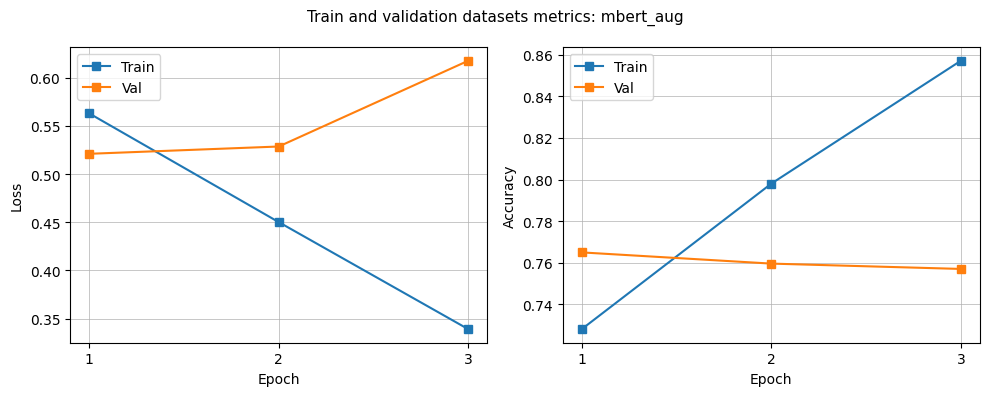

In [55]:
plot_metrics(model_mbert_aug.name, epochs=3)

We trained our model for 3 epochs and can see that the model trains very quickly. And 2 epochs look to be enough, otherwise the model gets overfitted.

* 4.3  (5%) Evaluate your fine-tuned model (use accuracy and MCC metrics and `in_domain_dev.csv` for the evaluation), analyze the results and make conclusions.

In [56]:
acc_test_mbert_aug, mcc_test_mbert_aug = test_model(model_mbert_aug, test[['sentence', 'acceptable']])

100%|██████████| 31/31 [00:04<00:00,  6.43it/s]


In [57]:
print(f'{acc_test_mbert_aug = :.2%}')
print(f'{mcc_test_mbert_aug = :.2f}')

acc_test_mbert_aug = 79.26%
mcc_test_mbert_aug = 0.37


The mBERT model's accuracy for RuCoLa + CoLa $\approx$ 79% and MCC > 0, i.e. the model's predictions are not random. So, we were able to fine-tune a large model for our task within some reasonable time, instead of building a new model from the scratch. In other words, we successfully applied the __transfer learning__ technique for our task.

### <a id="summary"></a>[10%] 5. Summary & results analysis

* 5.1    (5%) Compare the results of the all the tested models. First, compare them between each other, then with other models on [RuCoLa leaderboard](https://rucola-benchmark.com/leaderboard). Do not forget to mention, how the English data influences mBERT results.

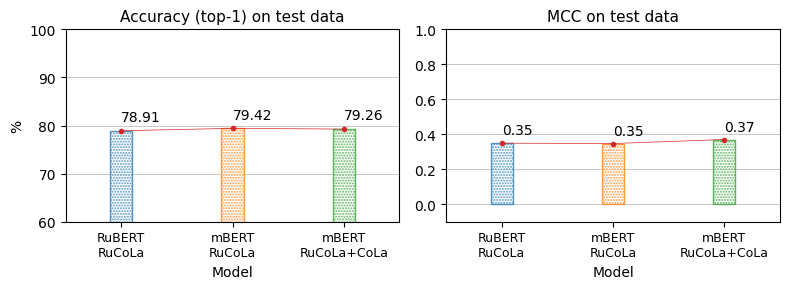

In [58]:
# Plot test accuracy and MCC for all models side by side
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.bar(['RuBERT\nRuCoLa', 'mBERT\nRuCoLa', 'mBERT\nRuCoLa+CoLa'], [acc_test_rubert*100, acc_test_mbert*100, acc_test_mbert_aug*100], color=['white', 'white', 'white'], edgecolor=['C0', 'C1', 'C2'], width=0.2, hatch='.'*6, alpha=0.75)
plt.plot([acc_test_rubert*100, acc_test_mbert*100, acc_test_mbert_aug*100], marker='.', color='C3', lw=0.5)
plt.text('RuBERT\nRuCoLa', acc_test_rubert*100+2, round(acc_test_rubert*100, 2))
plt.text('mBERT\nRuCoLa', acc_test_mbert*100+2, round(acc_test_mbert*100, 2))
plt.text('mBERT\nRuCoLa+CoLa', acc_test_mbert_aug*100+2, round(acc_test_mbert_aug*100, 2))
plt.xlim([-0.5, 2.5])
plt.ylim(60.0, 100.0)
plt.xlabel('Model')
plt.xticks(fontsize=9)
plt.ylabel('%')
plt.title('Accuracy (top-1) on test data', fontsize=11)
plt.grid(axis='y', lw=0.5)
plt.gca().set_axisbelow(True)

plt.subplot(1, 2, 2)
plt.bar(['RuBERT\nRuCoLa', 'mBERT\nRuCoLa', 'mBERT\nRuCoLa+CoLa'], [mcc_test_rubert, mcc_test_mbert, mcc_test_mbert_aug], color=['white', 'white', 'white'], edgecolor=['C0', 'C1', 'C2'], width=0.2, hatch='.'*6, alpha=0.75)
plt.plot([mcc_test_rubert, mcc_test_mbert, mcc_test_mbert_aug], marker='.', color='C3', lw=0.5)
plt.text('RuBERT\nRuCoLa', mcc_test_rubert+0.05, round(mcc_test_rubert, 2))
plt.text('mBERT\nRuCoLa', mcc_test_mbert+0.05, round(mcc_test_mbert, 2))
plt.text('mBERT\nRuCoLa+CoLa', mcc_test_mbert_aug+0.05, round(mcc_test_mbert_aug, 2))
plt.xlim([-0.5, 2.5])
plt.ylim(-0.1, 1.0)
plt.xlabel('Model')
plt.xticks(fontsize=9)
plt.title('MCC on test data', fontsize=11)
plt.grid(axis='y', lw=0.5)
plt.gca().set_axisbelow(True)
plt.tight_layout();

We can see that all 3 models have roughly the same level of accuracy. At the same time, mBERT trained on RuCoLa + CoLa (augmented) has slightly higher MCC. The reason for this is most likely 2+ times more training data, since we combined two corpora. So, adding new English train data improved our multilingual classifier.

Comparing with the leaderboard models, as per both metrics, all our 3 models are unfortunately worse.

* 5.2    (5%) Propose, how you may improve the model score (write at least three ideas).

- Use more data for training from various contexts and language usage scenarios. We have seen that adding more examples may help improve model metrics;
- Tune learning rate. During training / validation two learning rates were tested: 1e-3 and 2e-5, and eventually 2e-5 was chosen as providing better accuracy;
- Tune tokenizer: try to train for longer sentences. We used only 64 tokens max;
- Try another optimizer, like Adagrad, Adadelta, etc. In this task only AdamW was used;
- Try other models / architectures. We can see that even within the BERT family, models can perform differently.

* 5.3 It is also interesting to see how our fine-tuned model infers from real unseen data. Let's try to predict the acceptance of some random sentences both in Russian and English. For that, we'll use mBERT trained on RuCoLa + CoLa.

In [59]:
sentences = [
    'А у нас сегодня кошка родила вчера котят.',
    'Зайчик вышел погулял.',
    'Я спросит с работы.',
    'I was worked today.',
    'Skynet will take over the world.',
    'John talked us.'
    ]
for sent in sentences:    
    output = model_mbert_aug.model(**model_mbert_aug.tokenizer(sent, return_tensors='pt').to(device)).logits.argmax(-1).item()
    print(f'{sent} -> Good') if output == 1 else print(f'{sent} -> Bad')

А у нас сегодня кошка родила вчера котят. -> Good
Зайчик вышел погулял. -> Bad
Я спросит с работы. -> Good
I was worked today. -> Bad
Skynet will take over the world. -> Good
John talked us. -> Bad


Looks like the model can classify the acceptance of random unseen texts in most cases.

In [60]:
# Done with this model, can clear the cuda cache now
del model_mbert_aug
torch.cuda.empty_cache()
gc.collect()
torch.cuda.is_available()

True

Sources:
- <a href="https://edu.hse.ru/course/view.php?id=182084">Introduction to Deep Learning</a>
- <a href="https://huggingface.co/ai-forever/ruBert-base">Hugging Face - ruBert-base</a>
- <a href="https://huggingface.co/bert-base-multilingual-cased">Hugging Face - BERT multilingual base model (cased)</a>
- <a href="https://mccormickml.com/2019/07/22/BERT-fine-tuning/">BERT Fine-Tuning Tutorial with PyTorch</a>

### General Requirements

* You should provide a solution in the form of the Jupyter Notebook with code cells and markdown cells (with text).
* Make sure that the instructor can run all the cells to reproduce your results.
* Clearly answer each question, perform the required actions from the task. Explain your decisions if you choose to use some techniques.
* Provide links to the tutorials you use for reference.